In [8]:
import numpy as np
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt

In [16]:
label_path = './input/labels.csv'
image_path = './input/head_ct/head_ct'

label_df = pd.read_csv(label_path)
image_files = sorted(glob.glob(image_path + '/*.png'))
label_df

,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
195,195,0
196,196,0
197,197,0
198,198,0


In [10]:
from torchvision import transforms, datasets, utils
from PIL import Image, ImageEnhance

In [11]:
T = transforms.Compose([transforms.RandomResizedCrop((128, 128),
                                                     scale=(0.6, 1),
                                                     ratio=(0.5, 2)),
                        transforms.RandomRotation(30),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip()])

In [62]:
def feature_engineering(img):
    img = Image.fromarray(img)  # openCV to PIL

    img = ImageEnhance.Contrast(img)  # 1 contrast enhancement
    contrast = 2
    img = img.enhance(contrast)
    img = np.asarray(img)  # PIL to openCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 2 gray scale
    thresh = (img.max() - img.min()) // 1.3  # binarize threshold
    _, img = cv2.threshold(img, thresh, 1, cv2.THRESH_BINARY)  # 3 binarize
    img = cv2.medianBlur(img, 7)  # 4 median blur
    img = cv2.erode(img, np.ones((3, 3), np.uint8), iterations=2)  # 5 erode
    img = cv2.resize(img, (128, 128))  # 6 resize

    return img

In [80]:
def loadDataset(image_files, multiplier, label_df, T):
    X = []
    y = []

    for image_file in image_files:
        image_id = int(image_file.split('/')[-1].split('.')[0])
        label = label_df.loc[label_df['id'] == image_id,' hemorrhage'].values[0]
        img = cv2.imread(image_file)
        img = feature_engineering(img)
        X.append(img)
        y.append(label)
        img = Image.fromarray(img)
        for _ in range(multiplier):
            imgT = T(img)
            X.append(imgT)
            y.append(label)

    return np.array(X), np.array(y)

In [81]:
m = 4
X, y = loadDataset(image_files, m, label_df, T)

/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


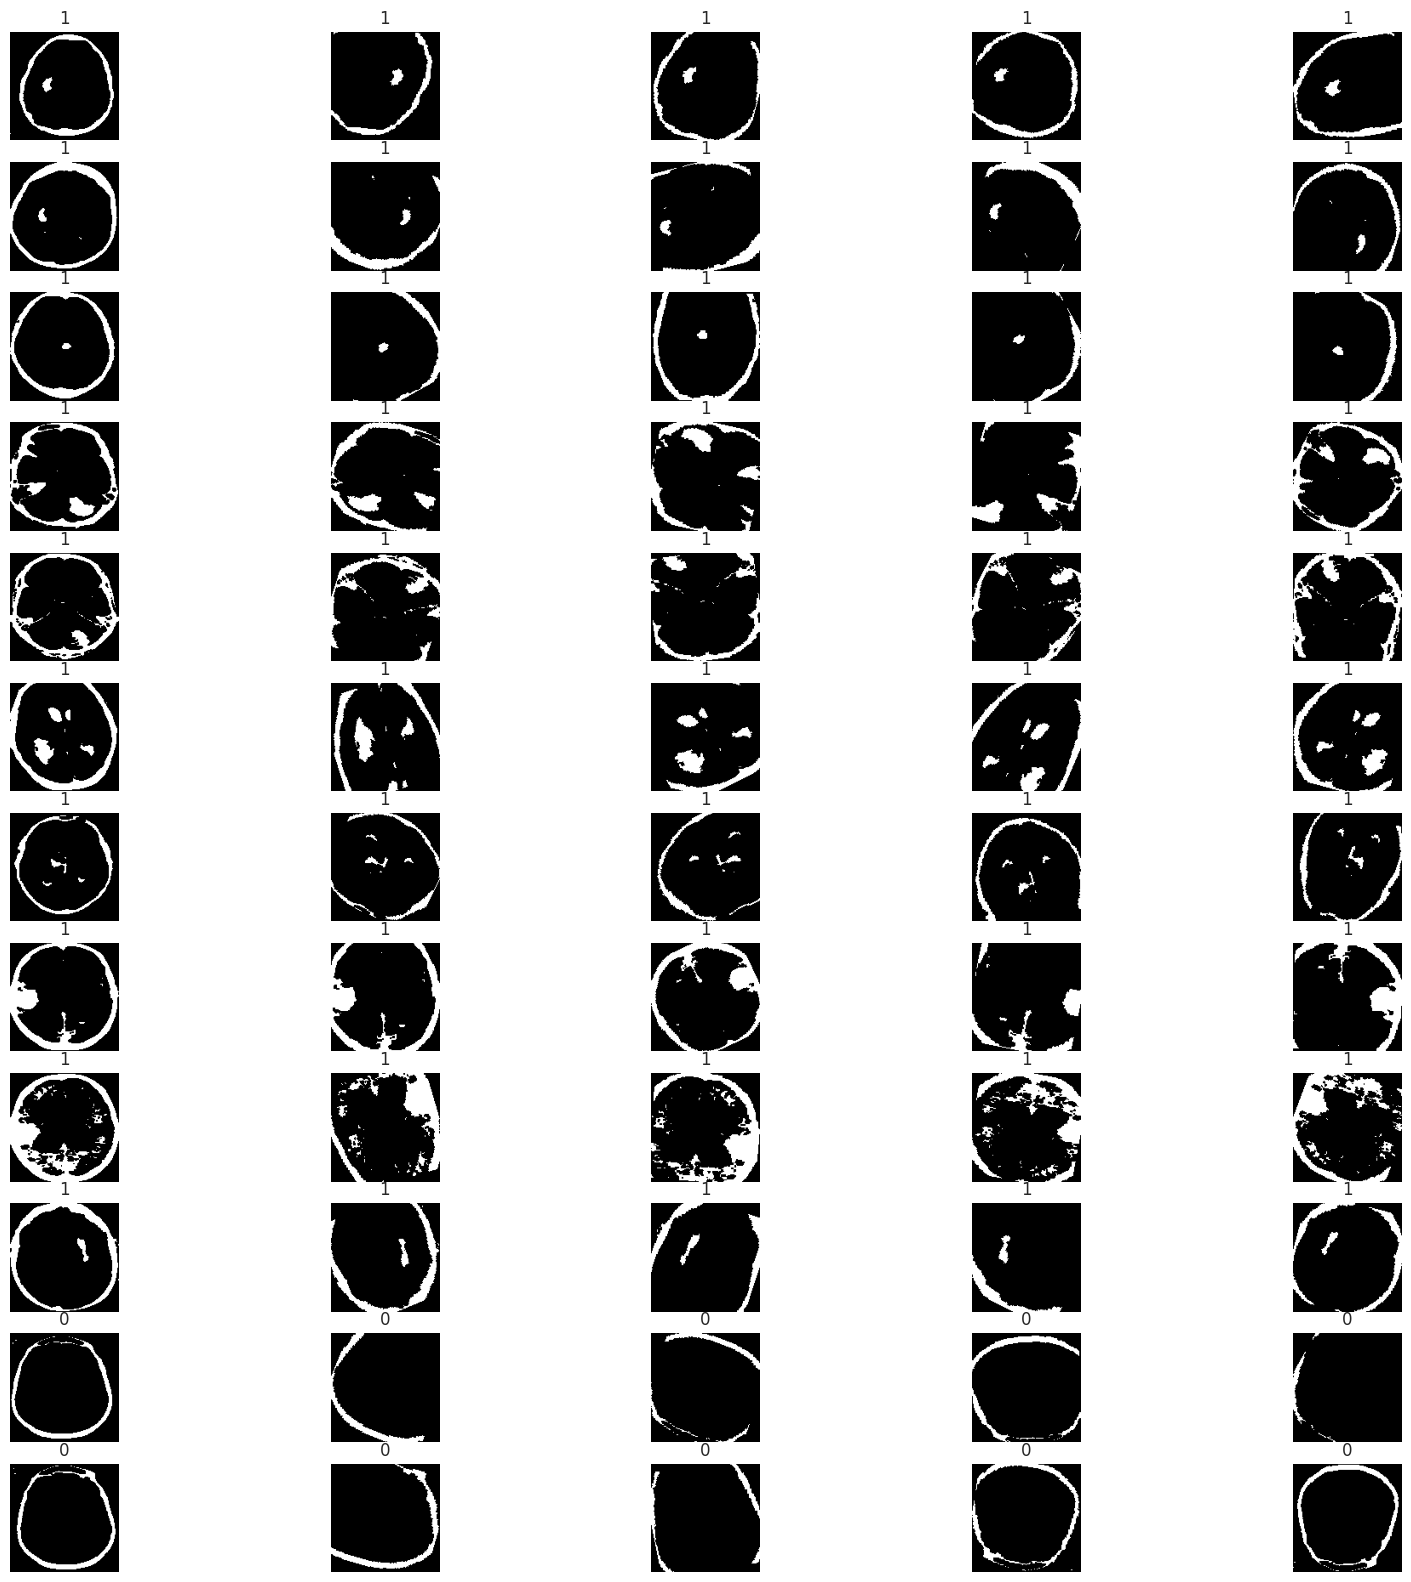

In [84]:
plt.figure(figsize=(20, 20))
for i in range(60):
    plt.subplot(12, 5, i+1)
    plt.imshow(X[i+450], cmap='gray')
    plt.title(y[i+450])
    plt.axis('off')